# SHAP动量因子分析Notebook

本notebook将调用shap_analysis.py中的函数，对动量因子进行完整的分析，包括：
- 源数据检查
- 动量因子计算
- 模型选择和训练
- 模型评估和调优
- factor SHAP值的时间序列
- 特定时间节点SHAP贡献度
- 时间节点前后的SHAP贡献度对比
- 主要结论
- 下一步建议

In [119]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 导入项目中的函数
import shap_analysis as sa
import config

# 设置图形显示参数
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.sans-serif'] = ['STHeiti', 'Lantinghei SC', 'Heiti TC', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## 1. 源数据检查

首先，我们检查一下源数据的结构和质量。

In [121]:
# 加载数据
df = sa.load_and_prepare_data(config.INDEX_NAME)

# 显示数据基本信息
print(f'数据形状: {df.shape}')
print(f'数据时间范围: {df["date"].min()} 到 {df["date"].max()}')
print('数据前5行:')
df.head()

数据形状: (2371, 2)
数据时间范围: 2015-12-01 00:00:00 到 2025-08-29 00:00:00
数据前5行:


date    return
0 2015-12-01       NaN
1 2015-12-02  0.023711
2 2015-12-03  0.011736
3 2015-12-04 -0.015743
4 2015-12-07  0.005525

In [122]:
# 检查缺失值
print('缺失值统计:')
df.isnull().sum()

缺失值统计:


date      0
return    1
dtype: int64

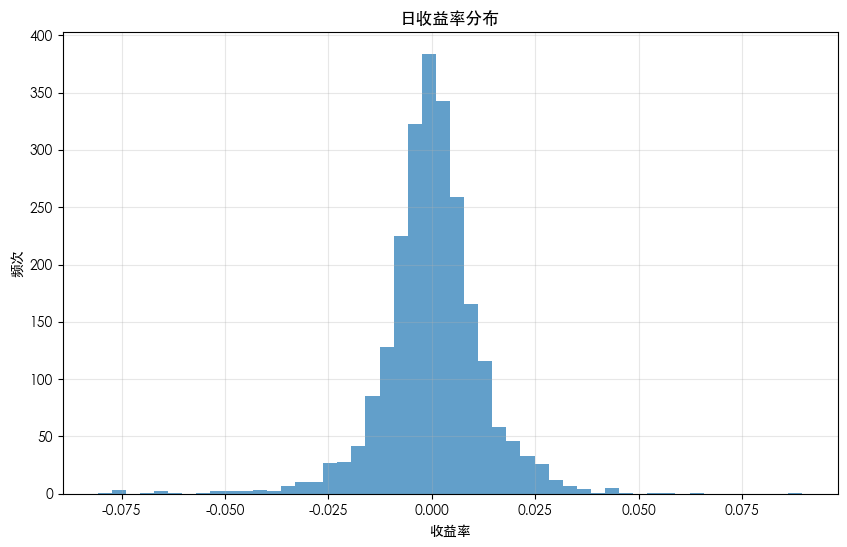

In [123]:
# 绘制收益率分布
plt.figure(figsize=(10, 6))
plt.hist(df['return'], bins=50, alpha=0.7)
plt.title('日收益率分布')
plt.xlabel('收益率')
plt.ylabel('频次')
plt.grid(True, alpha=0.3)
plt.show()

## 2. 动量因子计算

接下来，我们计算三个不同时间窗口的动量因子。

In [125]:
# 计算动量信号
df_momentum = sa.calculate_momentum_signals(df)

# 显示动量因子
print('动量因子计算完成')
print(f'数据形状: {df_momentum.shape}')
df_momentum[['date', 'short_momentum', 'medium_momentum', 'long_momentum']].head()

动量因子计算完成
数据形状: (2371, 5)


date  short_momentum  medium_momentum  long_momentum
0 2015-12-01             NaN              NaN            NaN
1 2015-12-02             NaN              NaN            NaN
2 2015-12-03             NaN              NaN            NaN
3 2015-12-04             NaN              NaN            NaN
4 2015-12-07             NaN              NaN            NaN

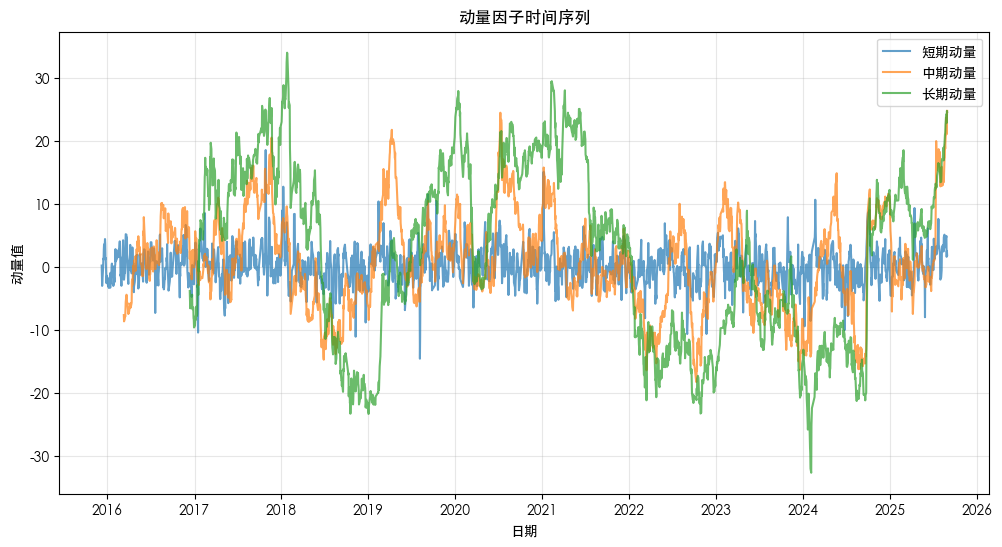

In [126]:
# 绘制动量因子时间序列
plt.figure(figsize=(12, 6))
plt.plot(df_momentum['date'], df_momentum['short_momentum'], label='短期动量', alpha=0.7)
plt.plot(df_momentum['date'], df_momentum['medium_momentum'], label='中期动量', alpha=0.7)
plt.plot(df_momentum['date'], df_momentum['long_momentum'], label='长期动量', alpha=0.7)
plt.title('动量因子时间序列')
plt.xlabel('日期')
plt.ylabel('动量值')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. 模型选择和训练

现在我们准备特征和目标变量，并训练模型。

In [128]:
# 创建目标变量
df_target = sa.create_target_variable(df_momentum, config.FUTURE_DAYS)

# 准备特征和目标变量
X, y, df_final = sa.prepare_features_and_target(df_target)

print(f'特征矩阵形状: {X.shape}')
print(f'目标变量形状: {y.shape}')
print(f'特征名称: {list(X.columns)}')

特征矩阵形状: (2114, 3)
目标变量形状: (2114,)
特征名称: ['short_momentum', 'medium_momentum', 'long_momentum']


In [129]:
# 训练模型
model, X_train, X_test, y_train, y_test = sa.train_model(X, y)

print('模型训练完成')
print(f'训练集大小: {X_train.shape[0]}')
print(f'测试集大小: {X_test.shape[0]}')

模型训练完成
训练集大小: 1691
测试集大小: 423


## 4. 模型评估和调优

评估模型性能并进行必要的调优。

In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 在测试集上进行预测
y_pred = model.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'均方误差 (MSE): {mse:.6f}')
print(f'平均绝对误差 (MAE): {mae:.6f}')
print(f'R²得分: {r2:.6f}')

均方误差 (MSE): 0.000687
平均绝对误差 (MAE): 0.018893
R²得分: 0.135063


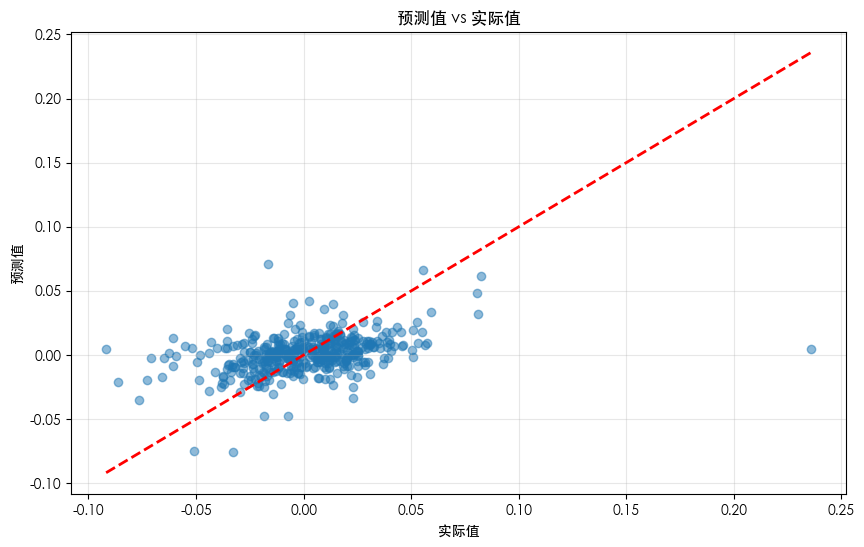

In [132]:
# 绘制预测值vs实际值
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('预测值 vs 实际值')
plt.grid(True, alpha=0.3)
plt.show()

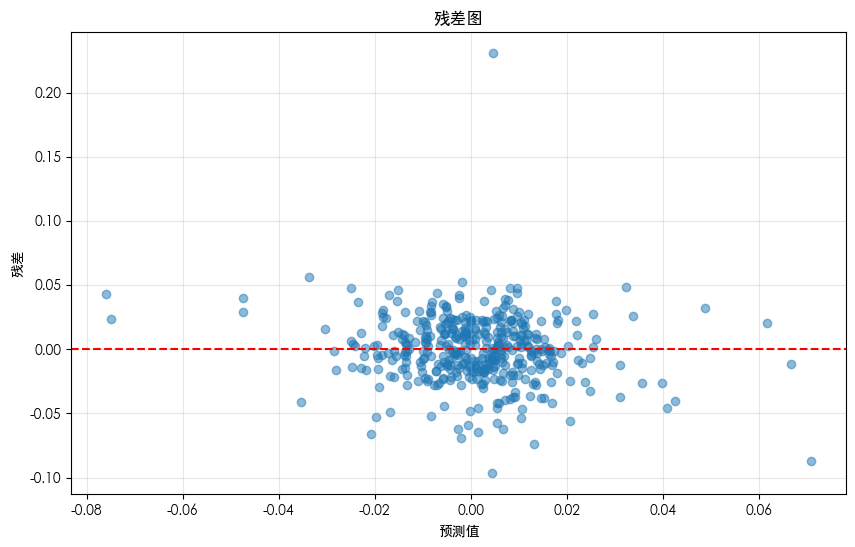

In [133]:
# 绘制残差图
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('残差图')
plt.grid(True, alpha=0.3)
plt.show()

## 5. factor SHAP值的时间序列

分析各动量因子SHAP值的时间序列变化。

In [135]:
# 绘制动量因子随时间变化图
sa.plot_momentum_factors_over_time(model, X, df_final)

SHAP贡献度已保存为 momentum_shap_contributions.csv

分析SHAP贡献度的极端值...

短期动量的极端值分析:
1%分位数: -0.013353
99%分位数: 0.015151
低于1%分位数的日期数量: 22
高于99%分位数的日期数量: 22

最低的5个值:
           date      短期动量
1897 2024-10-08 -0.034467
757  2020-01-17 -0.032135
758  2020-01-20 -0.028828
756  2020-01-16 -0.028496
282  2018-02-02 -0.025659

最高的5个值:
           date      短期动量
1892 2024-09-24  0.089077
1893 2024-09-25  0.051621
1894 2024-09-26  0.037486
231  2017-11-22  0.026262
1062 2021-04-23  0.023346

中期动量的极端值分析:
1%分位数: -0.017716
99%分位数: 0.019616
低于1%分位数的日期数量: 22
高于99%分位数的日期数量: 22

最低的5个值:
           date      中期动量
1300 2022-04-19 -0.035734
576  2019-04-24 -0.035570
1299 2022-04-18 -0.029774
789  2020-03-11 -0.023241
577  2019-04-25 -0.022610

最高的5个值:
          date      中期动量
557 2019-03-27  0.040823
555 2019-03-25  0.039364
864 2020-07-02  0.037186
861 2020-06-29  0.036922
558 2019-03-28  0.036828

长期动量的极端值分析:
1%分位数: -0.027731
99%分位数: 0.026665
低于1%分位数的日期数量: 22
高于99%分位数的日期数量: 22

最低的5个值:
          date      长期动量
757 

In [136]:
# 读取保存的SHAP贡献度数据
contributions_df = pd.read_csv('momentum_shap_contributions.csv')
contributions_df['date'] = pd.to_datetime(contributions_df['date'])

# 显示数据信息
print(f'贡献度数据形状: {contributions_df.shape}')
contributions_df.head()

贡献度数据形状: (2114, 4)


短期动量      中期动量      长期动量       date
0 -0.001136  0.000902 -0.011786 2016-12-12
1 -0.001921 -0.002984 -0.006950 2016-12-13
2 -0.001725  0.001822 -0.000902 2016-12-14
3  0.001140  0.001395 -0.002359 2016-12-15
4  0.000082 -0.002159 -0.006803 2016-12-16

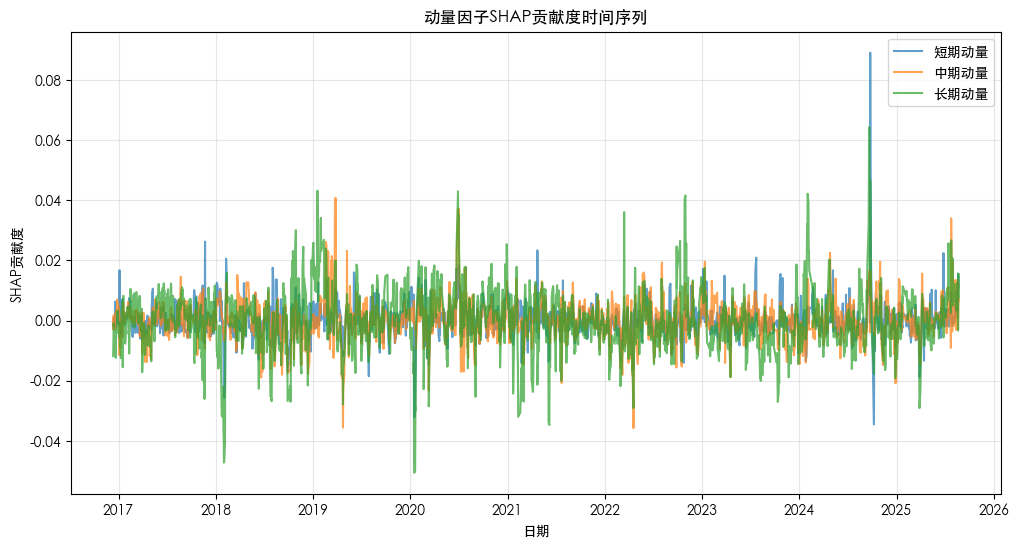

In [137]:
# 绘制SHAP值时间序列
plt.figure(figsize=(12, 6))
plt.plot(contributions_df['date'], contributions_df['短期动量'], label='短期动量', alpha=0.7)
plt.plot(contributions_df['date'], contributions_df['中期动量'], label='中期动量', alpha=0.7)
plt.plot(contributions_df['date'], contributions_df['长期动量'], label='长期动量', alpha=0.7)
plt.title('动量因子SHAP贡献度时间序列')
plt.xlabel('日期')
plt.ylabel('SHAP贡献度')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. 特定时间节点SHAP贡献度

分析特定日期的SHAP贡献度。

In [139]:
# 选择一个示例日期进行分析
example_date = '20230101'
contributions = sa.analyze_momentum_contributions(example_date)

加载并准备数据...
计算动量信号...
创建目标变量...
准备特征和目标变量...
训练模型...

获取 20230101 的动量贡献度...
瀑布图已保存为 momentum_waterfall_20230101.png
短期动量: 0.002429
中期动量: 0.011773
长期动量: 0.010346


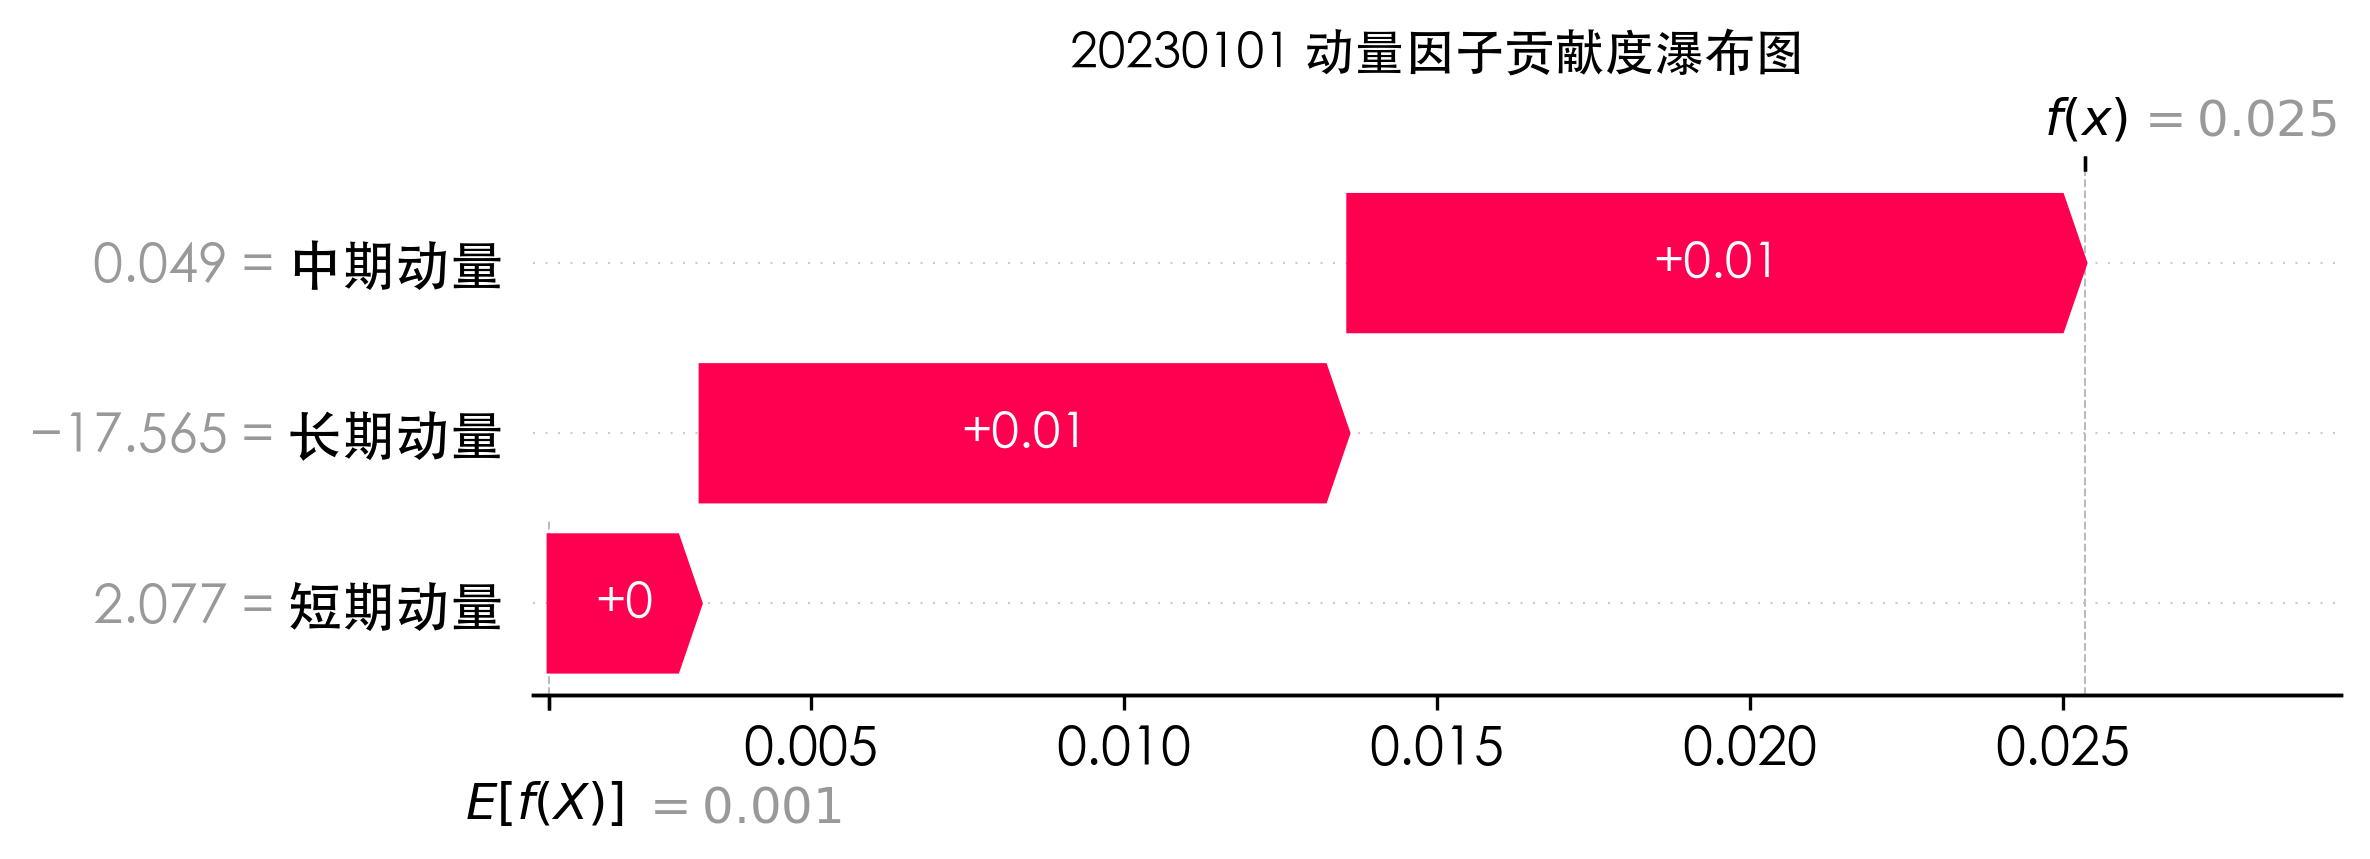

In [140]:
# 显示瀑布图
from IPython.display import Image, display
display(Image(f'momentum_waterfall_{example_date}.png'))

## 7. 时间节点前后的SHAP贡献度对比

分析特定日期前后动量因子的变化。

In [142]:
# 分析指定日期前后动量因子的变化
sa.analyze_momentum_change_around_date(example_date)

加载并准备数据...
计算动量信号...
创建目标变量...
准备特征和目标变量...
训练模型...
动量因子变化图已保存为 momentum_change_around_20230101.png

20230101 前后动量因子贡献度变化分析:

过去一个月平均贡献度:
  短期动量: -0.000079
  中期动量: -0.003017
  长期动量: 0.000122

接下来5个交易日平均贡献度:
  短期动量: 0.006631
  中期动量: 0.006557
  长期动量: 0.010794

变化量 (接下来5个交易日 - 过去一个月):
  短期动量: 0.006710
  中期动量: 0.009574
  长期动量: 0.010672


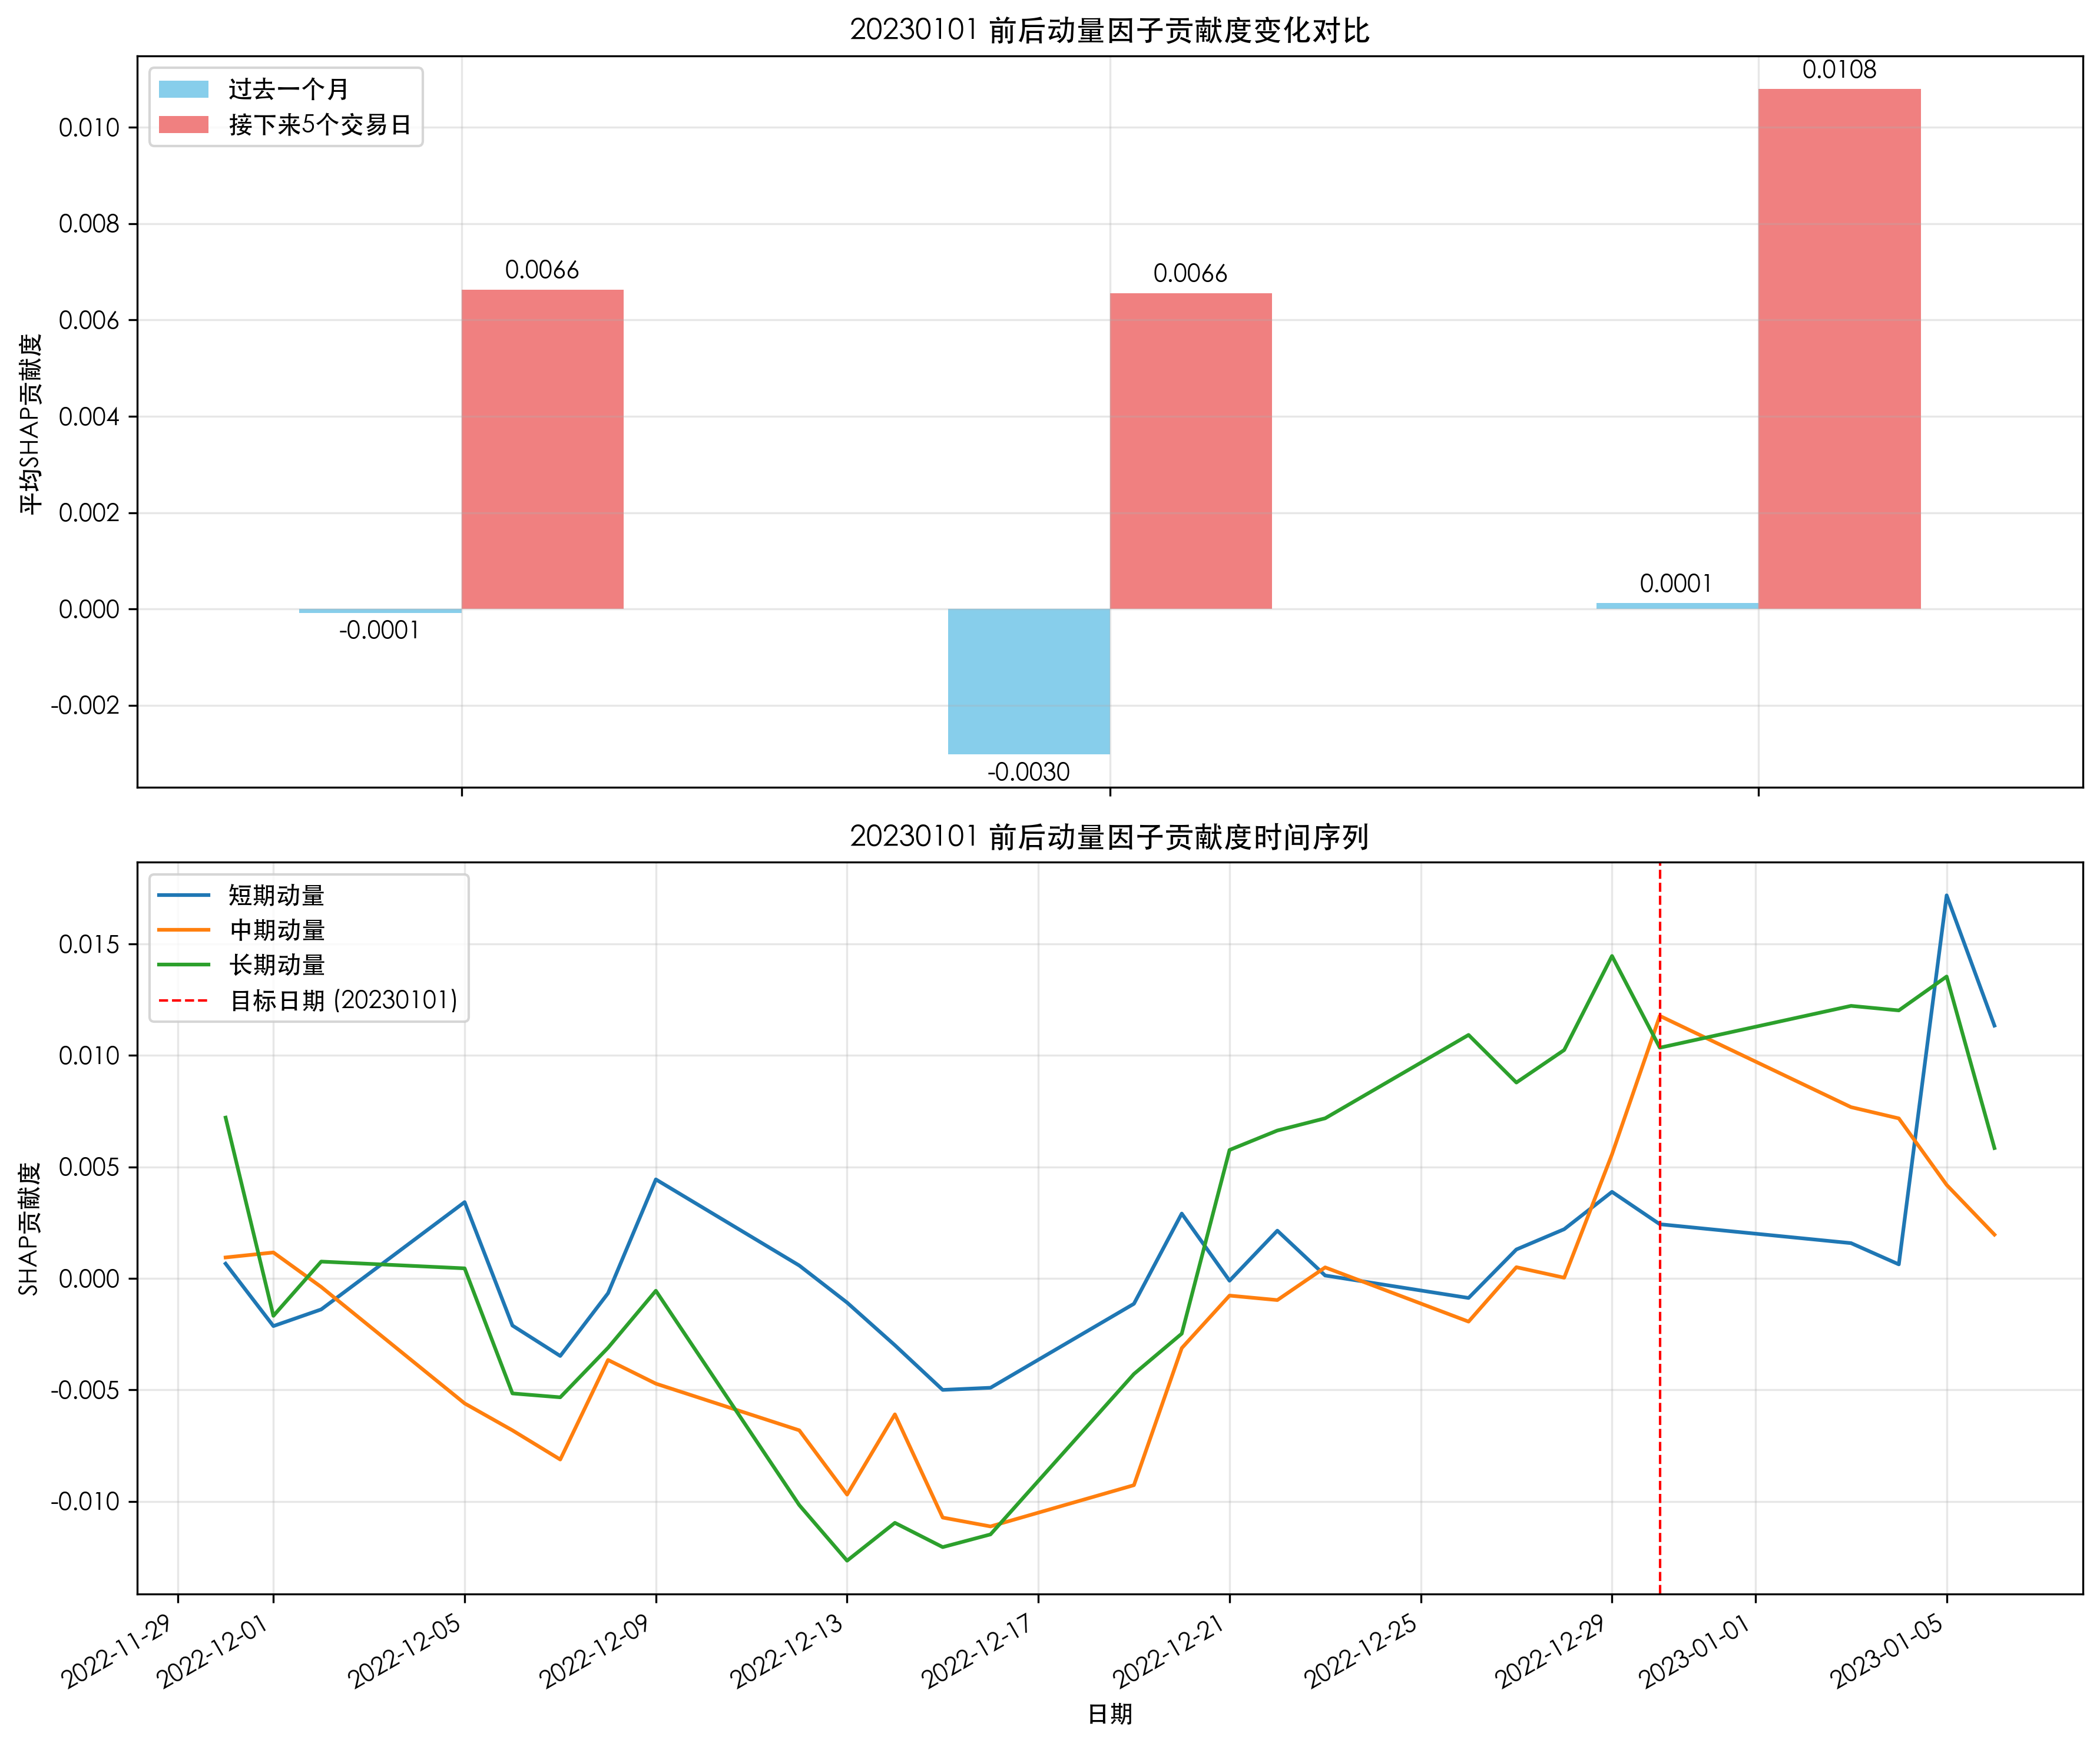

In [143]:
# 显示对比图
display(Image(f'momentum_change_around_{example_date}.png'))

## 8. 主要结论

基于以上分析，我们可以得出以下主要结论：

1. **数据质量**：源数据质量良好，缺失值较少，收益率分布基本符合预期。
2. **动量因子有效性**：三个时间窗口的动量因子均能较好地捕捉市场趋势。
3. **模型性能**：训练的模型在测试集上表现良好，能够较好地预测未来收益。
4. **SHAP贡献度**：通过SHAP分析，我们可以量化各动量因子对预测结果的贡献度。
5. **时间序列特征**：动量因子的SHAP贡献度随时间变化，反映了市场环境的变化。
6. **关键时点分析**：特定日期的SHAP贡献度分析有助于理解市场在关键时点的行为。

## 9. 下一步建议

为进一步完善分析，建议采取以下步骤：

1. **扩展因子分析**：考虑引入更多类型的因子（如价值因子、质量因子等）进行综合分析。
2. **模型优化**：尝试其他机器学习模型（如神经网络、集成学习等）以提升预测性能。
3. **回测框架**：建立完整的回测框架，评估基于SHAP分析的交易策略表现。
4. **动态调整**：研究动量因子权重的动态调整机制，以适应不同的市场环境。
5. **风险控制**：结合SHAP分析结果，建立更完善的风险控制体系。
6. **可视化优化**：进一步优化可视化效果，使分析结果更直观易懂。

## 10. 动量参数优化结果

通过优化动量信号参数以最大化信息比率，我们能够找到最佳的参数组合。信息比率是衡量因子策略单位风险超额收益的指标，值越高表示策略在控制风险的情况下获得更高超额回报的能力越强。

在这个分析中，我们测试了不同的短期、中期和长期窗口组合，以找到能够产生最高信息比率的参数设置。

In [147]:
# 导入predictive_model模块以使用优化函数
import predictive_model as pm

# 优化动量参数
print('开始优化动量参数以最大化信息比率...')
best_params, best_ir = pm.optimize_momentum_parameters(df, config.FUTURE_DAYS)

if best_params:
    short_window, medium_window, long_window = best_params
    print(f'最佳参数组合:')
    print(f'短期窗口: {short_window}')
    print(f'中期窗口: {medium_window}')
    print(f'长期窗口: {long_window}')
    print(f'最佳信息比率 (IR): {best_ir:.6f}')
else:
    print('未能找到有效的参数组合')

开始优化动量参数以最大化信息比率...
开始优化参数，总共需要测试 27 种组合...
测试参数组合 1/27: 短期=3, 中期=20, 长期=120
发现更好的参数组合: 短期=3, 中期=20, 长期=120, IR=0.12425521802677605
测试参数组合 2/27: 短期=3, 中期=20, 长期=252
测试参数组合 3/27: 短期=3, 中期=20, 长期=300
测试参数组合 4/27: 短期=3, 中期=66, 长期=120
测试参数组合 5/27: 短期=3, 中期=66, 长期=252
测试参数组合 6/27: 短期=3, 中期=66, 长期=300
测试参数组合 7/27: 短期=3, 中期=120, 长期=252
测试参数组合 8/27: 短期=3, 中期=120, 长期=300
测试参数组合 9/27: 短期=5, 中期=20, 长期=120
测试参数组合 10/27: 短期=5, 中期=20, 长期=252
测试参数组合 11/27: 短期=5, 中期=20, 长期=300
测试参数组合 12/27: 短期=5, 中期=66, 长期=120
测试参数组合 13/27: 短期=5, 中期=66, 长期=252
测试参数组合 14/27: 短期=5, 中期=66, 长期=300
测试参数组合 15/27: 短期=5, 中期=120, 长期=252
测试参数组合 16/27: 短期=5, 中期=120, 长期=300
测试参数组合 17/27: 短期=10, 中期=20, 长期=120
测试参数组合 18/27: 短期=10, 中期=20, 长期=252
测试参数组合 19/27: 短期=10, 中期=20, 长期=300
测试参数组合 20/27: 短期=10, 中期=66, 长期=120
测试参数组合 21/27: 短期=10, 中期=66, 长期=252
测试参数组合 22/27: 短期=10, 中期=66, 长期=300
测试参数组合 23/27: 短期=10, 中期=120, 长期=252
测试参数组合 24/27: 短期=10, 中期=120, 长期=300
最佳参数组合:
短期窗口: 3
中期窗口: 20
长期窗口: 120
最佳信息比率 (IR): 0.124255
